In [73]:
import numpy,pandas
from sklearn.decomposition import PCA

#For the preprocessing we need the data from Dream9.xlsx
Dream9_training=pandas.read_excel('Dream9.xlsx',"trainingData") 
Dream9_scoring=pandas.read_excel('Dream9.xlsx',"scoringData")
Dream9=pandas.concat([Dream9_training,Dream9_scoring])

#Division of types of Variables
All=list(Dream9_training.keys())
Sc=list(Dream9_scoring.keys())

#Dependent variables are present in the training set but not in the scoring set
Dependent=[]
for v in All:
    if v not in Sc:
        Dependent+=[v]

#Categorical variables have discrete values and can't be measured by euclidean distances
Categorical=['SEX', 'PRIOR.MAL', 'PRIOR.CHEMO', 'PRIOR.XRT', 'Infection', 'cyto.cat', 
             'ITD', 'D835', 'Ras.Stat', 'resp.simple', 'Relapse', 'vital.status']

#The last 231 variables are proteins
Protein=All[-231:]

###############
#  Functions  #
###############

def alias(Series,aliases):
    #Changes the values on a Series with aliases as a dict that transform the old values in the new values
    new_Series=(Series=='This creates and new series')
    for key,data in zip(Series.keys(),Series):
        new_Series[key]=False
        for val in aliases:
            try:
                if numpy.isnan(data):
                    new_Series[key]=numpy.nan
            except:
                pass             
            if data==val:
                new_Series[key]=aliases[val]
                break
    return new_Series

def make_pca(Table,All_Data,n,name='PCA'):
    pca = PCA(n_components=n)
    pca.fit(All_Data[Table.keys()])
    trans_PCA=pca.transform(Table)
    return pandas.DataFrame(trans_PCA,columns=['%s_%i'%(name,i+1) for i in range(n)],index=Table.index)

def split(Series,All_Data):
    #For Series with multiple values, creates a table with a column for each unique value
    #The value is True for the correct column and False for all the other columns
    D=[]
    for value in All_Data[Series.name].unique():
        q=(Series==value)
        q.name='%s=%s'%(q.name,value)
        D+=[q]
    return pandas.concat(D,axis=1)


def difference_from_mean(Table,All_Data):
    #This function creates a new Table with the values equal to (value-mean)/std
    #Since most of the values are already centered around 0 it woul be better to just take the square?
    D=[]
    for i,var in enumerate(Table.keys()):
        m=All_Data[var].mean()
        std=All_Data[var].std()
        D+=[(Table[var]-m)**2/std]
        D[i].name='%s_Normalized'%var
    return pandas.concat(D,axis=1)

def squared(Table):
    #This function squares all the values on a table
    D=[]
    for i,var in enumerate(Table.keys()):
        D+=[Table[var]**2]
        D[i].name='%s_Squared'%var
    return pandas.concat(D,axis=1)

def cutoff(Series,cutoff):
    #This function makes values above a threeshold equal to the threeshold
    new_Series=Series.copy()
    for key,data in zip(Series.keys(),Series):
        if data>cutoff:
            new_Series[key]=cutoff
        else:
            new_Series[key]=data
    new_Series.name='%s_cut'%Series.name
    return new_Series

def binned(Series,bins=[0,52,104]):
    #This function will bin the results from Remission and Overall Survival as expected    
    bins = numpy.array(bins)
    digitized = list(numpy.digitize(Series, bins))
    for i,v in enumerate(Series):
        if numpy.isnan(v):
            digitized[i]=numpy.nan
    return pandas.Series(digitized,index=Series.index,name='%s_binned'%Series.name)*52-26
####################
#  Pre-processing  #
####################    
    
def PreProcess(table,Dream9):
    #Select all variables that are not Categorical
    Tables=[table[[v for v in table.keys() if v not in Categorical]]]
    
    #Convert yes/no to 1/0
    Alias_Dict={'SEX':{'F':1},'PRIOR.MAL':{'YES':1},'PRIOR.CHEMO':{'YES':1},'PRIOR.XRT':{'YES':1},
                'Infection':{'Yes':1},'ITD':{'POS':1,'ND':numpy.nan},'D835':{'POS':1,'ND':numpy.nan},
                'Ras.Stat':{'POS':1,'NotDone':numpy.nan},'resp.simple':{'CR':1},'Relapse':{'Yes':1},
                'vital.status':{'A':1}}
    Aliased=[]
    for key in Alias_Dict:
        if key in table.keys():
            Aliased+=[alias(table[key],Alias_Dict[key])]
    Tables+=[pandas.concat(Aliased,axis=1)]
    
    #Split data that has multiple values
    Tables+=[split(table['cyto.cat'],Dream9)]
    
    #Create new data for protein
    #Tables+=[difference_from_mean(table[Protein],Dream9)]
    
    #Create new data for protein
    Tables+=[squared(table[Protein])]
    Tables+=[make_pca(table[Protein],Dream9,200)]
    Tables+=[make_pca(squared(table[Protein]),squared(Dream9[Protein]),200,name='PCA_Sq')]
    
    Cut=[]
    for key in ['Overall_Survival','Remission_Duration']:
        if key in table.keys():
            Cut+=[cutoff(table[key],130)]
    if len(Cut)>0:
        Tables+=[pandas.concat(Cut,axis=1)]
        
    Bin=[]
    for key in ['Overall_Survival','Remission_Duration']:
        if key in table.keys():
            Bin+=[binned(table[key])]
    if len(Bin)>0:
        Tables+=[pandas.concat(Bin,axis=1)]
    
    
    #Join everything
    return pandas.concat(Tables,axis=1)

Q_Dependent=Dependent+['Overall_Survival_cut','Remission_Duration_cut','Overall_Survival_binned','Remission_Duration_binned']
if __name__=='__main__':
   
    #This part is to test the function

    #Open the data and read in pandas
    Dream9_training=pandas.read_excel('Dream9.xlsx',"trainingData")
    Dream9_scoring=pandas.read_excel('Dream9.xlsx',"scoringData")
    Dream9=pandas.concat([Dream9_training,Dream9_scoring])

    #Create the new tables
    Q_training=PreProcess(Dream9_training,Dream9)
    Q_scoring=PreProcess(Dream9_scoring,Dream9)

    #Save the tables as csv
    Q_training.to_csv('Qtraining.csv')
    Q_scoring.to_csv('Qscoring.csv')

    #Number of columns and rows of new Table
    print Q_training.shape
    print Q_scoring.shape
    #A=binned(Dream9_training['Remission_Duration'])

(187, 918)
(70, 909)


In [80]:
#Correlation for Continuous variables
Corr=pandas.DataFrame()
for Variable in Q_Dependent:
    C=Q_training[[t for t in Q_training.keys() if (t not in Q_Dependent)]+[Variable]].corr()[Variable][:-1]
    Corr=Corr.append(C)
#Write correlation as csv
Corr.to_csv('Correlations.csv')

#for Variable in Q_Dependent:
#    print Corr.T.sort(Variable)[Variable][Corr.T.sort(Variable)[Variable]**2>0.2**2]
#Select most important variables for prediction
#Variables_for_prediction={'pCR':'resp.simple','pRelapse':'Relapse','OS':'Overall_Survival_cut','Remission':'Remission_Duration_cut'}
#for Pred in Variables_for_prediction:
#    Variable=Variables_for_prediction[Pred]
#    print Corr.T.sort(Variable)[Variable][Corr.T.sort(Variable)[Variable]**2>0.2**2]
#    Selected_variables.update({Pred:Corr.T.sort(Variable)[Variable][Corr.T.sort(Variable)[Variable]**2>0.2**2].index})


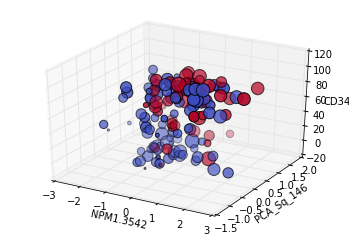

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
%matplotlib inline

x = Q_training['NPM1.3542']
y = Q_training['PCA_Sq_146']
z = Q_training['CD34']
area = Q_training['PCA_4']*25+75 # 0 to 15 point radiuses
colors = Q_training['resp.simple']

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel(x.name)
ax.set_ylabel(y.name)
ax.set_zlabel(z.name)
ax.scatter(x, y, z,s=area, c=colors,cmap=matplotlib.cm.coolwarm_r)
#Blue is 1 and red is 0
plt.show()

In [106]:
#Calculate how much information in gained on each column
#Calculate the entropy of the subset
import numpy as np
def information_gain(Table,Dependent,Independent):
    Table=Table[Table[Dependent].notnull()]
    freq=[]
    for dval in Table[Dependent].unique():
        freq+=[sum(Table[Dependent]==dval)]
    Freq=[float(f)/sum(freq) for f in freq]
    E=0
    for f in Freq:
        E+=-f*np.log(f)/np.log(2)
    #print 'Subset Entropy:', E
    Vars=[]

    #Calculate the entropy of each variable
    for ind in Independent:     
        if ind in Categorical:
            IG=E
            for ival in Table[ind].unique():
                if np.isnan(ival):
                    continue
                SubTable=Table[Table[ind]==ival]
                #print SubTable
                freq=[]
                for dval in Table[Dependent].unique():
                    freq+=[sum(SubTable[Dependent]==dval)]
                Freq=[float(f)/sum(freq) for f in freq]
                #print Freq
                ES=0
                for f in Freq:
                    ES+=-f*np.log(f)/np.log(2) if f<>0 else 0
                #print ES
                IG-=float(len(SubTable))/len(Table)*ES
            #print 'Information gain from %s: %f'%(ind,IG)
            Vars+=[(IG,ind)]
        else:
            Threeshold=[]
            prev_SubTableA_len=0
            for ival in np.arange(min(Table[ind]),max(Table[ind]),(max(Table[ind])-min(Table[ind]))/500.0):
                IG=E
                SubTableA=Table[Table[ind]<ival]
                SubTableB=Table[Table[ind]>=ival]
                if len(SubTableA)<1 or len(SubTableB)<1:
                    continue
                if len(SubTableA)==prev_SubTableA_len:
                    continue
                else:
                    prev_SubTableA_len=len(SubTableA)
                freq=[]
                for dval in Table[Dependent].unique():
                    freq+=[sum(SubTableA[Dependent]==dval)]
                Freq=[float(f)/sum(freq) for f in freq]
                #print Freq
                ES=0
                for f in Freq:
                    ES+=-f*np.log(f)/np.log(2) if f<>0 else 0
                #print ES
                IG-=float(len(SubTableA))/len(Table)*ES
                #print SubTable
                freq=[]
                for dval in Table[Dependent].unique():
                    freq+=[sum(SubTableB[Dependent]==dval)]
                Freq=[float(f)/sum(freq) for f in freq]
                #print Freq
                ES=0
                for f in Freq:
                    ES+=-f*np.log(f)/np.log(2) if f<>0 else 0
                #print ES
                IG-=float(len(SubTableB))/len(Table)*ES
                Threeshold+=[(IG,ival)]
            Threeshold.sort(reverse=True)
            #print Threeshold
            #break
            #print 'Information gain from %s: %f at theeshold:%f'%(ind,Threeshold[0][0],Threeshold[0][1])
            if len(Threeshold)>0:
                Vars+=[(Threeshold[0][0],ind,Threeshold[0][1])]
            else:
                Vars+=[(0,ind)]
    Information_gain=pandas.Series([v[0] for v in Vars],index=[v[1] for v in Vars],name='Information Gain')
    Threesholds=pandas.Series([v[2] for v in Vars if len(v)>2],index=[v[1] for v in Vars if len(v)>2],name='Threeshold')
    return pandas.concat([Information_gain,Threesholds],axis=1)

Q_Cat=['resp.simple','Relapse','vital.status','Overall_Survival_binned','Remission_Duration_binned']
Ts=[]
for Variable in Q_Cat:
    print Variable
    Independent=[v for v in Q_training.keys() if v in Q_scoring.keys()]
    Ts+=[information_gain(Q_training,Variable,Independent)]
Information_Gain=pandas.concat(Ts,keys=Q_Cat,axis=1)
Information_Gain.to_csv('InformationGain.csv')

resp.simple
Relapse
vital.status
Overall_Survival_binned
Remission_Duration_binned


In [108]:
Information_Gain.head()

resp.simple                        Relapse                 \
              Information Gain   Threeshold  Information Gain     Threeshold   
ABS.BLST              0.013173  1432.320000          0.017354  128908.800000   
ACTB                  0.018276     1.066289          0.017445      -1.410872   
ACTB_Squared          0.019667     2.568551          0.021364       1.984172   
AHD                   0.042226     4.032000          0.032191       1.152000   
AIFM1                 0.016801    -1.603635          0.012618      -2.289655   

                  vital.status                 Overall_Survival_binned  \
              Information Gain     Threeshold         Information Gain   
ABS.BLST              0.012376  242778.240000                 0.041707   
ACTB                  0.024918       1.604431                 0.042195   
ACTB_Squared          0.022158       2.351108                 0.028055   
AHD                   0.031290       6.048000                 0.018307   
AIFM1                 0.024918       2.298488                 0.026182   

                           Remission_Duration_binned               
               Threeshold           Information Gain   Threeshold  
ABS.BLST      2148.480000                   0.040286  2148.480000  
ACTB            -0.479801                   0.049096     0.160844  
ACTB_Squared     0.353346                   0.039949     2.011353  
AHD              6.048000                   0.023465   100.224000  
AIFM1           -1.410461                   0.036445     0.551584  

[5 rows x 10 columns]

In [104]:
#Debugging
Table=Q_training
Dependent='resp.simple'
Independent=[v for v in Q_training.keys() if v in Q_scoring.keys()]
Table=Table[Table[Dependent].notnull()]
freq=[]
for dval in Table[Dependent].unique():
    freq+=[sum(Table[Dependent]==dval)]
Freq=[float(f)/sum(freq) for f in freq]
E=0
for f in Freq:
    E+=-f*np.log(f)/np.log(2)
#print 'S
Vars=[]
for ind in [v for v in Independent if v in Categorical]:
    IG=E
    for ival in Table[ind].unique():
        if np.isnan(ival):
            continue
        SubTable=Table[Table[ind]==ival]
        #print SubTable
        freq=[]
        for dval in Table[Dependent].unique():
            freq+=[sum(SubTable[Dependent]==dval)]
        Freq=[float(f)/sum(freq) for f in freq]
        #print Freq
        ES=0
        for f in Freq:
            ES+=-f*np.log(f)/np.log(2) if f<>0 else 0
        #print ES
        IG-=float(len(SubTable))/len(Table)*ES
    #print 'Information gain from %s: %f'%(ind,IG)
    Vars+=[(IG,ind)]